<a href="https://colab.research.google.com/github/akshatamadavi/cmpe258-assignment-3/blob/main/%5Bcolab_d%5Dightning_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Layer DNN for Nonlinear Regression
## PyTorch Lightning — Self-Contained Notebook

Everything is generated inside the notebook. No external data files needed.

| What | How |
|---|---|
| Data | Generated inline:  |
| Model | 3-layer MLP via  |
| Logging | Explicit  — reliable path |
| Backprop | Automatic via Lightning Trainer |

## 0. Install PyTorch Lightning

In [8]:
!pip install lightning -q
import lightning
print("Lightning version:", lightning.__version__)

Lightning version: 2.6.1


## 1. Imports

In [9]:
import os
import glob
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
from lightning.pytorch.loggers import CSVLogger

torch.manual_seed(42)
print("PyTorch:", torch.__version__)

PyTorch: 2.10.0+cu128


## 2. Generate Data (No External Files)

We generate  directly in code.

X shape: torch.Size([200, 1])
y shape: torch.Size([200, 1])


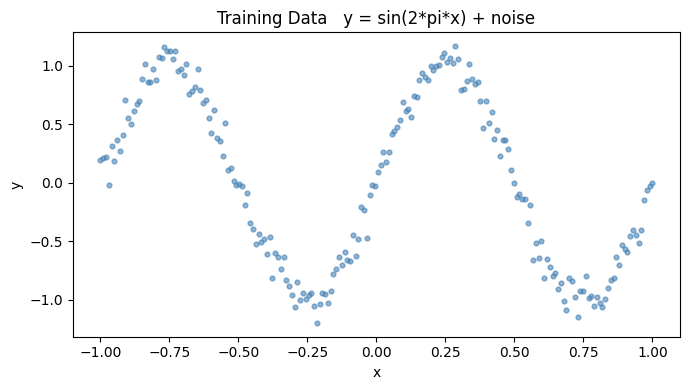

In [10]:
# --- Generate data ---
X = torch.linspace(-1, 1, 200).unsqueeze(1)           # shape (200, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.randn_like(X)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

plt.figure(figsize=(7, 4))
plt.scatter(X.numpy(), y.numpy(), s=12, alpha=0.6, color="steelblue")
plt.title("Training Data   y = sin(2*pi*x) + noise")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

## 3. DataLoader

In [11]:
dataset    = TensorDataset(X, y)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,     # 0 = main process, avoids Colab fork issues
)
print(f"Batches per epoch: {len(dataloader)}")

Batches per epoch: 7


## 4. LightningModule

Three methods are all Lightning needs:

| Method | Job |
|---|---|
|  | Network architecture + inference |
|  | Compute loss (Lightning handles backward + optimizer.step) |
|  | Return the optimizer |

In [12]:
class RegressionNet(L.LightningModule):
    """3-layer MLP for nonlinear regression."""

    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()    # saves all args to hparams

        self.net = nn.Sequential(
            nn.Linear(input_dim,  hidden_dim),   # Layer 1
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),   # Layer 2
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),   # Layer 3 -> output
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y  = batch
        y_hat = self(x)
        loss  = self.loss_fn(y_hat, y)
        # on_epoch=True  -> one averaged value logged per epoch (clean CSV)
        # on_step=False  -> suppresses noisy per-step rows
        self.log("train_loss", loss,
                 on_step=False, on_epoch=True,
                 prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


# Quick sanity check
_m = RegressionNet()
_x = torch.randn(4, 1)
print("Output shape:", _m(_x).shape)   # expect (4, 1)
del _m, _x

Output shape: torch.Size([4, 1])


## 5. Train

We attach an **explicit ** so we always know exactly where  lives.

In [13]:
LOG_DIR  = "my_logs"
EXP_NAME = "regression"

logger = CSVLogger(save_dir=LOG_DIR, name=EXP_NAME)

model = RegressionNet(hidden_dim=64, lr=1e-3)

trainer = L.Trainer(
    max_epochs=300,
    logger=logger,
    log_every_n_steps=1,     # safe: we only have ~7 steps/epoch
    enable_progress_bar=True,
    accelerator="auto",      # GPU if available, else CPU
    enable_checkpointing=True,
)

trainer.fit(model, dataloader)

csv_path = logger.experiment.metrics_file_path
print("metrics.csv saved at:", csv_path)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ net     │ Sequential │  4.4 K │ train │     0 │
│ 1 │ loss_fn │ MSELoss    │      0 │ train │     0 │
└───┴─────────┴────────────┴────────┴───────┴───────┘

Trainable params: 4.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


metrics.csv saved at: my_logs/regression/version_1/metrics.csv


## 6. Plot Loss from

Columns: ['epoch', 'step', 'train_loss']
   epoch  step  train_loss
0      0     6    0.498711
1      1    13    0.452410
2      2    20    0.431872
3      3    27    0.425301
4      4    34    0.421503


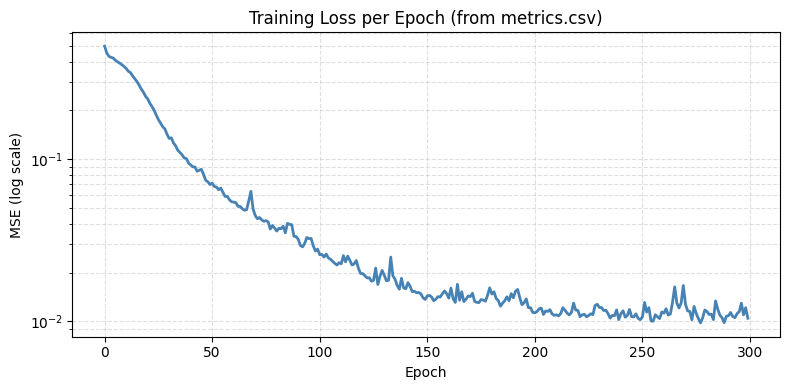

Final loss : 0.010459
Best  loss : 0.009793


In [14]:
csv_path = logger.experiment.metrics_file_path
df = pd.read_csv(csv_path)

print("Columns:", df.columns.tolist())
print(df.head())

# Drop rows where train_loss is NaN (step-level rows, if any)
epoch_df = df.dropna(subset=["train_loss"]).copy()

plt.figure(figsize=(8, 4))
plt.plot(epoch_df["epoch"].values, epoch_df["train_loss"].values,
         color="steelblue", linewidth=2)
plt.yscale("log")
plt.title("Training Loss per Epoch (from metrics.csv)")
plt.xlabel("Epoch")
plt.ylabel("MSE (log scale)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Final loss : {epoch_df['train_loss'].iloc[-1]:.6f}")
print(f"Best  loss : {epoch_df['train_loss'].min():.6f}")

## 7. Predictions vs Ground Truth

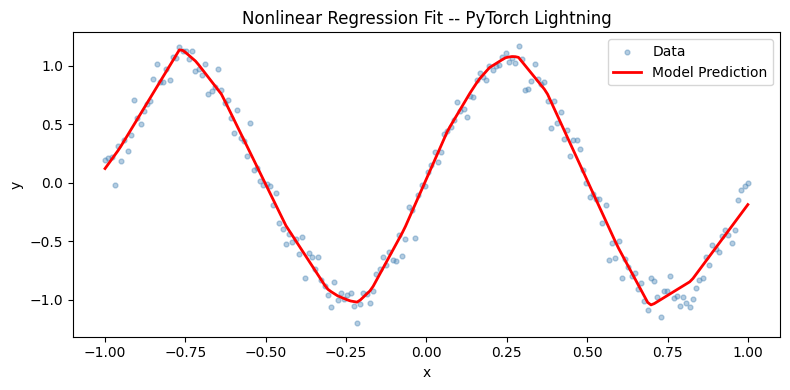

In [15]:
model.eval()
model.cpu()
with torch.no_grad():
    y_pred = model(X).numpy()

plt.figure(figsize=(8, 4))
plt.scatter(X.numpy(), y.numpy(), s=12, alpha=0.4,
            color="steelblue", label="Data")
plt.plot(X.numpy(), y_pred, color="red",
         linewidth=2, label="Model Prediction")
plt.title("Nonlinear Regression Fit -- PyTorch Lightning")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Reload from Checkpoint

In [16]:
ckpt_files = glob.glob(
    os.path.join(logger.log_dir, "checkpoints", "*.ckpt")
)
print("Checkpoint files found:")
for c in ckpt_files:
    print(" ", c)

if ckpt_files:
    loaded_model = RegressionNet.load_from_checkpoint(ckpt_files[-1])
    loaded_model.eval()
    loaded_model.cpu()
    with torch.no_grad():
        y_reload = loaded_model(X).numpy()
    max_diff = abs(y_reload - y_pred).max()
    print(f"Max abs diff (original vs reloaded): {max_diff:.2e}  (should be ~0)")
    print("Hyperparameters:", loaded_model.hparams)

Checkpoint files found:
  my_logs/regression/version_1/checkpoints/epoch=299-step=2100.ckpt
Max abs diff (original vs reloaded): 0.00e+00  (should be ~0)
Hyperparameters: "hidden_dim": 64
"input_dim":  1
"lr":         0.001
"output_dim": 1
